In [1]:
import tensorflow as tf
from tensorflow import keras

if tf.test.gpu_device_name()=='':
    print('You do not have GPU access.')
    !nvidia-smi

else:
  print('You have GPU access')
  !nvidia-smi


# print the tensorflow version
print('TensorFlow {}; Keras {}'.format(tf.__version__, keras.__version__))
tf.test.gpu_device_name()


You have GPU access
Tue Mar 29 15:26:42 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 496.49       Driver Version: 496.49       CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   74C    P3    17W /  N/A |    300MiB /  4096MiB |      2%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                    

'/device:GPU:0'

In [42]:
from tensorflow.keras import layers
import os
import tifffile as tiff
import numpy as np
from matplotlib import pyplot as plt
from keras.models import load_model
from preprocessing import get_model_memory_usage

#load pretrained model

model = load_model("models/ESnet_dice_noEmpty_v1.hdf5", compile=False)

batch_size = 2
print("Model uses {} GB of memory at a batch size of {}".format(get_model_memory_usage(batch_size, model), batch_size))

Model uses 1.264 GB of memory at a batch size of 2


In [43]:
model.summary()
for l in model.weights:
    print(l.name, l.shape)

Model: "ES-Net_V1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 3, 288, 288) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 288, 288) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 64, 288, 288) 1152        conv2d[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 64, 288, 288) 0           batch_normalization[0][0]        
__________________________________________________________________________________________

In [44]:
from preprocessing import patch_image, patch_stack, normalizePercentile, normalizeMinMax
from patchify import patchify

source_path = r"Bactnet/Training data/stacks/"
SIZE = 288




def prepare_data(source_path, PATCH_SIZE):
    pred_dict = {}
    stacks = os.listdir(os.path.join(source_path, "validation_source"))
    image_dataset = None
    mask_dataset = None
    for stack in stacks:
        if (stack.split(".")[-1]=="tif"):
            pred_dict[stack]={}
            img = tiff.imread(os.path.join(source_path, "validation_source",stack))
            pred_dict[stack]["image"]=img
            mask = tiff.imread(os.path.join(source_path, "validation_target", stack))
            pred_dict[stack]["y_true"]=mask
            print(stack, img.shape, mask.shape)
            
            img_patch = patch_stack(img, PATCH_SIZE)
            if len(mask.shape)==2:
                mask_patch = patch_image(mask, PATCH_SIZE)
            else:    
                mask_patch = patch_stack(mask, SIZE=PATCH_SIZE, DEPTH=1)
            
            print(stack, img_patch.shape, mask_patch.shape)
            mask_patch = normalizeMinMax(mask_patch)
            img_patch = normalizePercentile(img_patch, 0.1, 99.9, clip=True)
            pred_dict[stack]["image_patch"] = img_patch
            pred_dict[stack]["mask_patch"] = mask_patch


            #print(image_dataset.shape, mask_dataset.shape)

    return pred_dict

#pred_dict[file]=[image_stack, mask, patch, y_true, y_pred]
image_dict = prepare_data(source_path, SIZE)
print(image_dict.keys())



BT0398_210.tif (13, 2304, 2304) (11, 2304, 2304)
BT0398_210.tif (704, 3, 288, 288) (704, 1, 288, 288)
BT402_168.tif (5, 2304, 2304) (3, 2304, 2304)
BT402_168.tif (192, 3, 288, 288) (192, 1, 288, 288)
BT403_000.tif (13, 2304, 2304) (11, 2304, 2304)
BT403_000.tif (704, 3, 288, 288) (704, 1, 288, 288)
BT403_228.tif (13, 2304, 2304) (11, 2304, 2304)
BT403_228.tif (704, 3, 288, 288) (704, 1, 288, 288)
BT404_199.tif (3, 2304, 2304) (2304, 2304)
BT404_199.tif (64, 3, 288, 288) (64, 1, 288, 288)
dict_keys(['BT0398_210.tif', 'BT402_168.tif', 'BT403_000.tif', 'BT403_228.tif', 'BT404_199.tif'])


In [45]:
keras.backend.clear_session()
stride = 2

# #IOU
for stack in image_dict.keys():
    y_pred = None
    stackdict = image_dict[stack]
    
    for i in range(0, len(stackdict["image_patch"]), stride):
        pred = model.predict(stackdict["image_patch"][i:i+stride])
        if y_pred is not None:
            y_pred = np.concatenate((y_pred, pred))

        if y_pred is None:
            y_pred = pred
    
    image_dict[stack]["y_pred"] = y_pred
    print(stack, y_pred.shape)
    

BT0398_210.tif (704, 1, 288, 288)
BT402_168.tif (192, 1, 288, 288)
BT403_000.tif (704, 1, 288, 288)
BT403_228.tif (704, 1, 288, 288)
BT404_199.tif (64, 1, 288, 288)


In [46]:
from keras_unet_collection import losses
from preprocessing import unpatch_stack
from preprocessing import pad_stack, crop_stack, predict_stack


def crop_stack(arr, SIZE):
    """
    Undoes the padding from pad_stack, crops out the center, removing a 1/2 SIZE broder from around the stack
    """
    pad_SIZE = int(SIZE / 2)

    if len(arr.shape) == 3:
        t, y, x = arr.shape
        stopY = y - pad_SIZE
        stopX = x - pad_SIZE
        return arr[:, pad_SIZE:stopY, pad_SIZE:stopX]

    if len(arr.shape) == 4:
        t, c, y, x = arr.shape
        stopY = y - pad_SIZE
        stopX = x - pad_SIZE
        return arr[:, :, pad_SIZE:stopY, pad_SIZE:stopX]

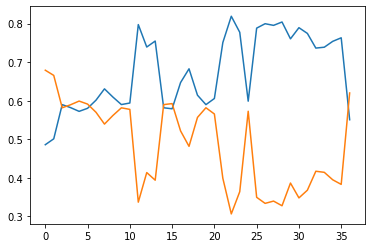

BT0398_210.tif (13, 2592, 2592) (11, 1, 2304, 2304) (11, 1, 2304, 2304)
BT402_168.tif (5, 2592, 2592) (3, 1, 2304, 2304) (14, 1, 2304, 2304)
BT403_000.tif (13, 2592, 2592) (11, 1, 2304, 2304) (25, 1, 2304, 2304)
BT403_228.tif (13, 2592, 2592) (11, 1, 2304, 2304) (36, 1, 2304, 2304)
BT404_199.tif (3, 2592, 2592) (1, 1, 2304, 2304) (37, 1, 2304, 2304)


(37, 1, 2304, 2304) (37, 1, 2304, 2304) (37, 1, 2304, 2304)


In [45]:
#length of each dataset
l_BT0398_210 = 11
l_BT402_168 = 3
l_BT403_000 = 11
l_BT403_228 = 11
l_BT404_199 = 1

In [47]:
outstack = None

for stack in image_dict.keys():
    #print(stack, image_dict[stack]["y_pred"].shape)
    image_dict[stack]["y_pred_stitch"] = unpatch_stack(image_dict[stack]["y_pred"], 8, 8, 1)[:,-1,:,:]
    #print(stack, image_dict[stack]["image"][1:-1].shape, image_dict[stack]["y_true"].shape, image_dict[stack]["y_pred_stitch"].shape)
    
    if len(image_dict[stack]["y_true"].shape)==2:
        image_dict[stack]["y_true"] = image_dict[stack]["y_true"].reshape((1, 2304, 2304))
    
    saveme = np.stack((image_dict[stack]["image"][1:-1], image_dict[stack]["y_true"], image_dict[stack]["y_pred_stitch"]), axis=1)
    #saveme = saveme * 65535
    saveme = saveme.astype('uint16')
    print(stack, saveme.shape)
    if outstack is None:
        outstack = saveme
    else:
        outstack = np.concatenate((outstack, saveme), axis=0)
    
print(outstack.shape)    
    

BT0398_210.tif (11, 3, 2304, 2304)
BT402_168.tif (3, 3, 2304, 2304)
BT403_000.tif (11, 3, 2304, 2304)
BT403_228.tif (11, 3, 2304, 2304)
BT404_199.tif (1, 3, 2304, 2304)
(37, 3, 2304, 2304)


In [25]:
print(image_dataset.shape, y_pre.shape, y_tru.shape)
saveme = np.concatenate((image_dataset, y_tru, y_pre, ypred_2), axis=1)
saveme = saveme * 65535
saveme = saveme.astype('uint16')
print(saveme.shape)

(37, 1, 2304, 2304) (37, 1, 2304, 2304) (37, 1, 2304, 2304)
(37, 4, 2304, 2304)


In [48]:
results_folder = r"_results"
tiff.imwrite(os.path.join(results_folder, "ES_all_stacks_v1.tif"), outstack, imagej=True, resolution=(1./2.6755, 1./2.6755),
                      metadata={'unit': 'um', 'finterval': 15,
                                'axes': 'TCYX'})

In [49]:
#Viktors data
source_path = r"Bactnet/viktor"
stacks = os.listdir(os.path.join(source_path))
print(stacks)
vikt = None

def predict_stack(arr, batch_size, model):
    """
    Performs prediction on all images in arr using model in increments of batch_size
    Assumes patches of a ahpe where N is 0th axis.
    """
    keras.backend.clear_session()
    y_pred = None
    for i in range(0, len(arr), batch_size):
        subset = arr[i:i + batch_size]
        
        pred = model.predict(subset)
        if y_pred is not None:
            y_pred = np.concatenate((y_pred, pred))

        else:
            y_pred = pred

    return y_pred

for i, image_name in enumerate(stacks):  # Remember enumerate method adds a counter and returns the enumerate object
    if (image_name.split('.')[-1] == 'tif'):
        image = tiff.imread(os.path.join(source_path, image_name))
        image = image[0:100]
        image = normalizePercentile(image, 0.1, 99.9, clip=True)
        patch = patch_stack(image, SIZE)
        print(image.shape, patch.shape)
        pred = predict_stack(patch, 2, model)
        pred = unpatch_stack(pred, 8, 8, 1)
        
        if vikt is None:
            vikt = pred 
        else:
            vikt = np.concatenate((vikt, pred))
        



['210218_murine-ML-hydrogel_60k-cells_A_2_inf_1_MMStack_Default.ome.tif']
(100, 2304, 2304) (6272, 3, 288, 288)


In [62]:
saveme = vikt * 65535
saveme = saveme.astype('uint16')
img = np.expand_dims(image[0:-2], axis = 1)
img = img * 65535
img = img.astype('uint16')
print(saveme.shape, img.shape)
saveme = np.concatenate((img,saveme), axis = 1)
print(saveme.shape)
tiff.imwrite(os.path.join(source_path, "pred.tif"), saveme, imagej=True, resolution=(1./0.109, 1./0.109),
                      metadata={'unit': 'um', 'finterval': 15,
                                'axes': 'TCYX'})



(98, 1, 2304, 2304) (98, 1, 2304, 2304)
(98, 2, 2304, 2304)


In [15]:


#load unseen data

validation_image_directory = r"C:\Users\analyst\Documents\Python Scripts\BactUnet\Bactnet\Training data\stacks\predict"
result_folder = r"C:\Users\analyst\Documents\Python Scripts\BactUnet\_results"

val_image_dataset = []
val_mask_dataset = []
pred_mask_dataset = []

images = os.listdir(validation_image_directory)

for i, image_name in enumerate(images):    #Remember enumerate method adds a counter and returns the enumerate object
    if (image_name.split('.')[1] == 'tif'):
        
        image = tiff.imread(os.path.join(validation_image_directory, image_name))
        original_shape = image.shape
        patch = patch_stack(image, SIZE)
        
        patch = normalizePercentile(patch, 0.1, 99.9, clip=True)
        pred_mask_patch = model.predict(patch)
        print(image_name, original_shape, patch.shape, pred_mask_patch.shape)
        #pred_mask_patch = pred_mask_patch[:, 0, :,:]
        image = np.expand_dims(patch[:, 1, :,:], axis=1)
        patch = np.concatenate((image, pred_mask_patch), axis=1)
        unpatched = unpatcher(patch, 8, 8, 2)
        print(patch.shape)
        tiff.imwrite(os.path.join(result_folder, image_name), unpatched, imagej=True, resolution=(1./2.6755, 1./2.6755),
                      metadata={'unit': 'um', 'finterval': 15,
                                'axes': 'TCYX'})
        
        #pred_mask = unpatch_stack(pred_mask_patch, original_shape)
        #tiff.imsave(os.path.join(result_folder, image_name), pred_mask_patch)
        #val_image_dataset.append(image)
        #pred_mask_dataset.append(pred_mask)

BT0398_210.tif (11, 2304, 2304) (576, 3, 288, 288) (576, 1, 288, 288)
(576, 2, 288, 288)
BT403_013.tif (12, 2304, 2304) (640, 3, 288, 288) (640, 1, 288, 288)
(640, 2, 288, 288)
BT403_216.tif (12, 2304, 2304) (640, 3, 288, 288) (640, 1, 288, 288)
(640, 2, 288, 288)
BT404_001.tif (12, 2304, 2304) (640, 3, 288, 288) (640, 1, 288, 288)
(640, 2, 288, 288)


In [34]:
for i in range(len(pred_mask_dataset)):
    img = val_image_dataset[i][3]
    msk = pred_mask_dataset[i][3]
    plt.figure(figsize=(16, 8))
    plt.subplot(121)
    plt.title('Testing Image')
    plt.imshow(img)
    plt.subplot(122)
    plt.title('Prediction on test image')
    plt.imshow(msk)
    plt.show()

1 conv2d (3, 3, 3, 64)
4 conv2d_1 (3, 3, 64, 64)
8 conv2d_2 (3, 3, 64, 128)
11 conv2d_3 (3, 3, 128, 128)
15 conv2d_4 (3, 3, 128, 256)
18 conv2d_5 (3, 3, 256, 256)
22 conv2d_6 (3, 3, 256, 512)
25 conv2d_7 (3, 3, 512, 512)
29 conv2d_8 (3, 3, 512, 1024)
32 conv2d_9 (3, 3, 1024, 1024)
35 conv2d_transpose (2, 2, 512, 1024)
37 conv2d_10 (3, 3, 1024, 512)
40 conv2d_11 (3, 3, 512, 512)
43 conv2d_transpose_1 (2, 2, 256, 512)
45 conv2d_12 (3, 3, 512, 256)
48 conv2d_13 (3, 3, 256, 256)
51 conv2d_transpose_2 (2, 2, 128, 256)
53 conv2d_14 (3, 3, 256, 128)
56 conv2d_15 (3, 3, 128, 128)
59 conv2d_transpose_3 (2, 2, 64, 128)
61 conv2d_16 (3, 3, 128, 64)
64 conv2d_17 (3, 3, 64, 64)
67 conv2d_18 (1, 1, 64, 1)


IndexError: index 3 is out of bounds for axis 2 with size 3

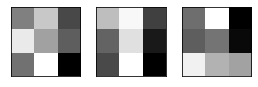

In [51]:
all_weights = []

for i, layer in enumerate(model.layers):
  if "onv" in layer.name:
    all_weights.append
    print(i, layer.name, model.layers[i].get_weights()[0].shape)

weights, biases =  model.layers[1].get_weights()
fig1=plt.figure(figsize=(12, 12))


columns = 8 
rows = 8 
n_filters = columns*rows
for i in range(1, n_filters +1):
    f = weights[:, :, (i-1), 0]
    fig1 =plt.subplot(rows, columns, i)
    fig1.set_xticks([])  #Turn off axis
    fig1.set_yticks([])

    #plt.imshow(f[i%3, :, :], cmap='gray')
    plt.imshow(f[:, :], cmap='gray')
    #plt.imshow(f[2, :, :], cmap='gray') #Show only the filters from 0th channel (R)
    #ix += 1
plt.show() 